## 3. Feature selection and EDA

In [272]:
# Import libraries
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
import json

from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim

import folium
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

from ipynb.fs.full.Modules import getLatLng, getNearbyVenues

In [273]:
df = pd.read_csv('df_dataCollection.csv')

In [274]:
df.head()

,Id,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Latitude,Longitude,restaurants,stores,transport,school,nightlife,golf,park,grocery,service,recreational,cultural,leisure
0,1,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,College Creek,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,None,None,0,2,2008,WD,Normal,208500,42.023708,-93.647577,8,6,2,5,8,1,1,2,2,2,3,1
1,3,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,College Creek,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,None,None,0,9,2008,WD,Normal,223500,42.023708,-93.647577,8,6,2,5,8,1,1,2,2,2,3,1
2,14,RL,91.0,10652,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,College Creek,Norm,Norm,1Fam,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,Stone,306.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,1494,1494,GasA,Ex,Y,SBrkr,0,1494,0,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,RFn,3,840,TA,TA,Y,160,33,0,0,0,0,0,None,None,0,8,2007,New,Partial,279500,42.023708,-93.647577,8,6,2,5,8,1,1,2,2,2,3,1
3,23,RL,75.0,9742,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,College Creek,Norm,Norm,1Fam,1Story,8,5,2002,2002,Hip,CompShg,VinylSd,VinylSd,BrkFace,281.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1777,1777,GasA,Ex,Y,SBrkr,0,1795,0,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,RFn,2,534,TA,TA,Y,171,159,0,0,0,0,0,None,None,0,9,2008,WD,Normal,230000,42.023708,-93.647577,8,6,2,5,8,1,1,2,2,2,3,1
4,33,RL,85.0,11049,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,College Creek,Norm,Norm,1Fam,1Story,8,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Ex,TA,Av,Unf,0,Unf,0,1234,1234,GasA,Ex,Y,SBrkr,0,1234,0,0,2,0,3,1,Gd,7,Typ,0,None,Attchd,RFn,2,484,TA,TA,Y,0,30,0,0,0,0,0,None,None,0,1,2008,WD,Normal,179900,42.023708,-93.647577,8,6,2,5,8,1,1,2,2,2,3,1


#### Distribution of target variable
Since house prices are unlikely to be normally distributed, we use the natural logarithm of the sale price to obtain a more gaussian distribution

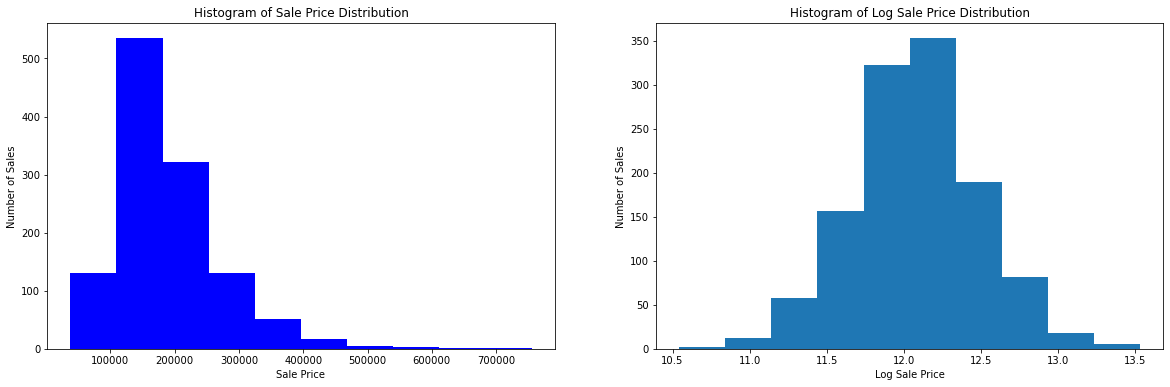

In [275]:
df['SalePrice_log'] = np.log(df['SalePrice'])

df_salePrice = df[['SalePrice', 'SalePrice_log']]

fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Histogram
df_salePrice['SalePrice'].plot(kind='hist', color='blue', figsize=(20, 6), ax=ax0) # add to subplot 1
ax0.set_title('Histogram of Sale Price Distribution')
ax0.set_xlabel('Sale Price')
ax0.set_ylabel('Number of Sales')

# Subplot 2: Histogram
df_salePrice['SalePrice_log'].plot(kind='hist', figsize=(20, 6), ax=ax1) # add to subplot 2
ax1.set_title ('Histogram of Log Sale Price Distribution')
ax1.set_xlabel('Log Sale Price')
ax1.set_ylabel('Number of Sales')

plt.show()

The feature data from the ames data set will be split into 11 categories: basement, bath, garage, kitchen, pool, fireplace, heating, masonry, porch, miscellaneous, and finally other features.

### Boxplot Neighborhoods

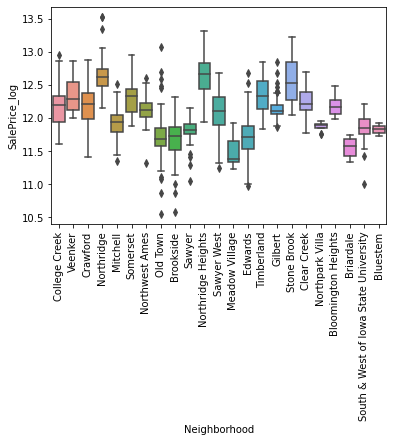

In [276]:
sns.boxplot(x=df['Neighborhood'], y=df['SalePrice_log'])
x=plt.xticks(rotation=90)

### 3.1 Basement

##### Categorical features 

We start by constructing dictionaries to get numerical inputs rather than strings

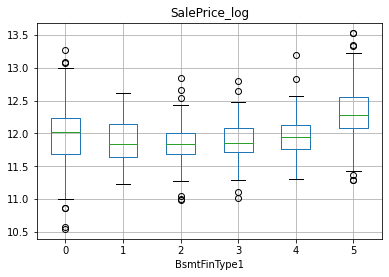

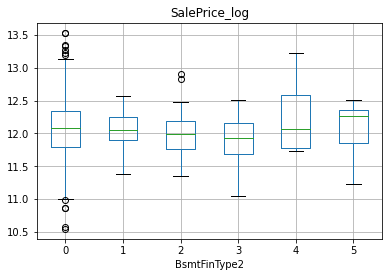

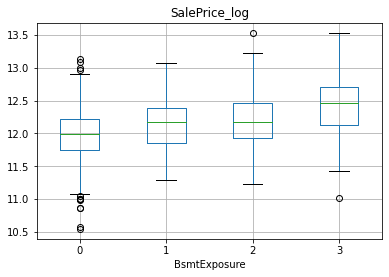

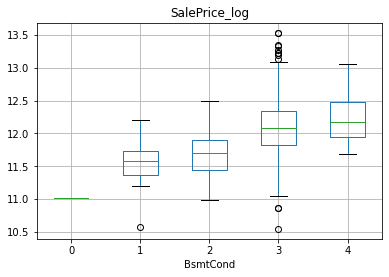

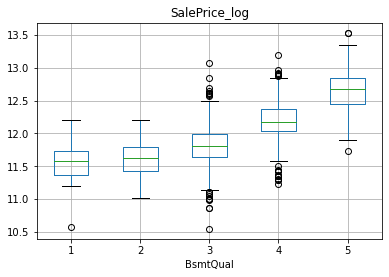

In [277]:
rank_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'None': 1, 'Po':0}
BsmtFin_dict = {'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':2, 'LwQ':1, 'Unf':0, 'None':0}
BsmtEx_dict = {'Gd':3, 'Av':2, 'Mn':1, 'No':0, 'None':0}

#  BsmtFinType1 & 2: Rating of basement finished area 1 and 2 (if multiple types)
df['BsmtFinType1'] = df.BsmtFinType1.replace(BsmtFin_dict)
df['BsmtFinType2'] = df.BsmtFinType2.replace(BsmtFin_dict)

# BsmtExposure: Refers to walkout or garden level walls
df['BsmtExposure'] = df.BsmtExposure.replace(BsmtEx_dict)

# BsmtCond: Condition of the basement
df['BsmtCond'] = df.BsmtCond.replace(rank_dict)

# BsmtQual: Evaluates the height of the basement
df['BsmtQual'] = df.BsmtQual.replace(rank_dict)

bsmt_cat_corr = df[['SalePrice_log','BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'BsmtCond', 'BsmtQual']].corr()
bsmt_cat_corr.style.background_gradient(cmap='coolwarm')

bsmt_cat = ['BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'BsmtCond', 'BsmtQual']

for bsmt in bsmt_cat:
    df.boxplot(column = 'SalePrice_log', by = bsmt)
    plt.suptitle('')
    plt.show()

While BsmtFinType1 abd BsmtFinType2 don't appear to add much predictive power, they connected with the BsmtFinSF1 and BsmtFinSF2 variables, we therefore attempt create two new interaction variables.


In [278]:
df['BsmtType1Inter'] = df['BsmtFinType1'] * df['BsmtFinSF1']
df['BsmtType2Inter'] = df['BsmtFinType2'] * df['BsmtFinSF2']

##### Numerical features 

In [279]:
temp_df = df[['SalePrice_log','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','BsmtType1Inter', 'BsmtType2Inter']]

correl = temp_df.corr()
correl.style.background_gradient(cmap='coolwarm')

,SalePrice_log,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,BsmtType1Inter,BsmtType2Inter
SalePrice_log,1.000000,0.373262,0.013206,0.227288,0.627814,0.236375,-0.009420,0.434490,0.023637
BsmtFinSF1,0.373262,1.000000,-0.035823,-0.508728,0.532076,0.680666,0.069234,0.963726,-0.057863
BsmtFinSF2,0.013206,-0.035823,1.000000,-0.200565,0.096093,0.149631,0.062579,-0.072826,0.915971
BsmtUnfSF,0.227288,-0.508728,-0.200565,1.000000,0.402513,-0.457338,-0.103336,-0.441240,-0.169397
TotalBsmtSF,0.627814,0.532076,0.096093,0.402513,1.000000,0.308745,-0.009923,0.549305,0.075971
BsmtFullBath,0.236375,0.680666,0.149631,-0.457338,0.308745,1.000000,-0.133929,0.685542,0.142584
BsmtHalfBath,-0.009420,0.069234,0.062579,-0.103336,-0.009923,-0.133929,1.000000,0.055725,0.049957
BsmtType1Inter,0.434490,0.963726,-0.072826,-0.441240,0.549305,0.685542,0.055725,1.000000,-0.087336
BsmtType2Inter,0.023637,-0.057863,0.915971,-0.169397,0.075971,0.142584,0.049957,-0.087336,1.000000


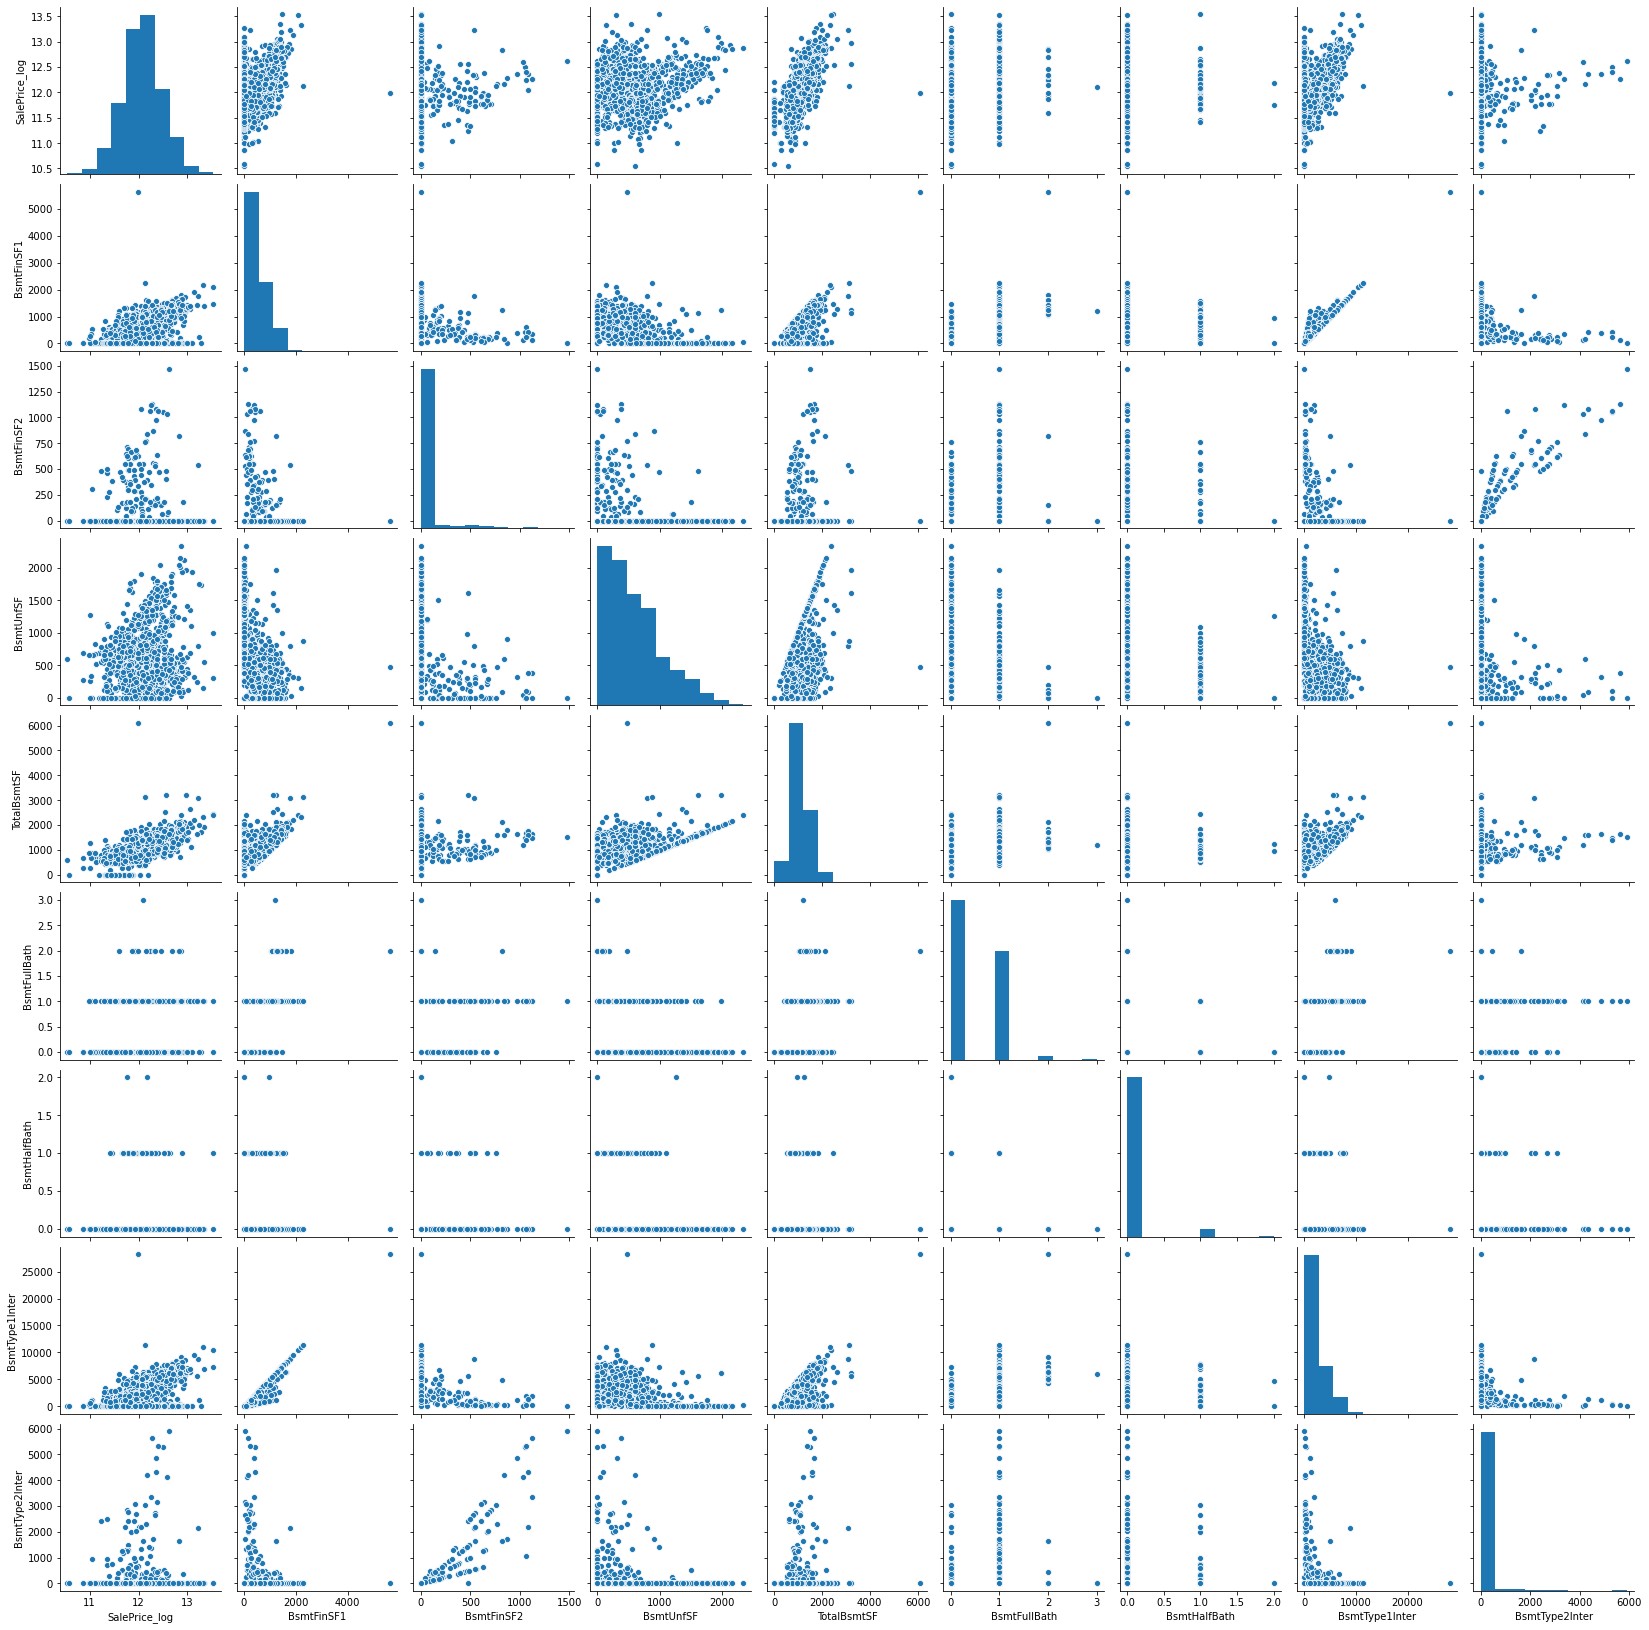

In [280]:
sns.pairplot(temp_df)

#### Basement summary:

##### Categorical:
From the boxplots above it is evident that BsmtCond, BsmtQual have some clear predictive power, while BsmtExposure display some evidence of predictive power. However, BsmtFinType1 and BsmtFinType2 show no predictive power.

##### Numerical:
From the scatter plots and heat map, we observe that very little explanatory power from BsmtUnfSF, BsmtFinSF2 and BsmtFullBath, BsmtHalfBath. To save running time and prevent overfitting we remove them. We did not see any significant improvement in the predictive performance of BsmtFinType1 and BsmtFinType2 after interacting with BsmtFinSF1, BsmtFinSF2. We therefore drop the interaction terms. BsmtFinSF1 is also removed due to the strong correlation with the TotalBsmtSF variable. 


In [281]:
df.drop(['BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 
         'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtType1Inter', 'BsmtType2Inter'], axis = 1, inplace = True)

### 3.2 Garage

#### Categorical variables for Garage

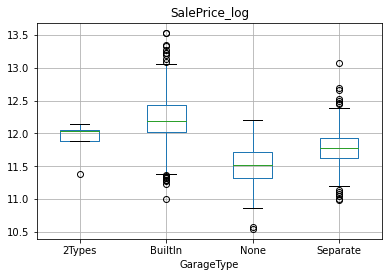

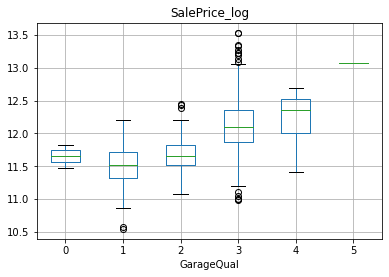

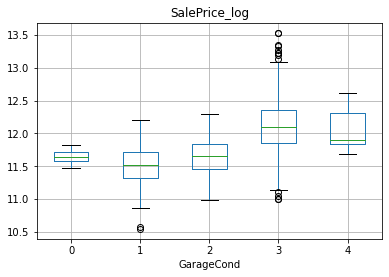

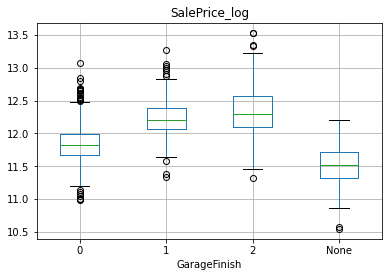

In [282]:
rank_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'None': 1, 'Po':0}
GarFin_dict = {'Fin':2, 'RFn':1, 'Unf':0}
GarType_dict = {'2Types': '2Types', 'Attchd': 'BuiltIn', 'Basment': 'BuiltIn', 'CarPort': 'Separate', 
               'Detchd': 'Separate'}

# Garage Quality and Condition
df['GarageQual'] = df.GarageQual.replace(rank_dict)
df['GarageCond'] = df.GarageCond.replace(rank_dict)
df['GarageFinish'] = df.GarageFinish.replace(GarFin_dict)

# Since type of garage is either built in the house or separate from the house, we can categorize some of them together:
df['GarageType'] = df['GarageType'].replace(GarType_dict)
df.loc[df['GarageType'].isna(), 'GarageType'] = 'None'

# Garage 
g_cat = ['GarageType', 'GarageQual', 'GarageCond', 'GarageFinish']

for gar in g_cat:
    df.boxplot(column = 'SalePrice_log', by = gar)
    plt.suptitle('')
    plt.show()

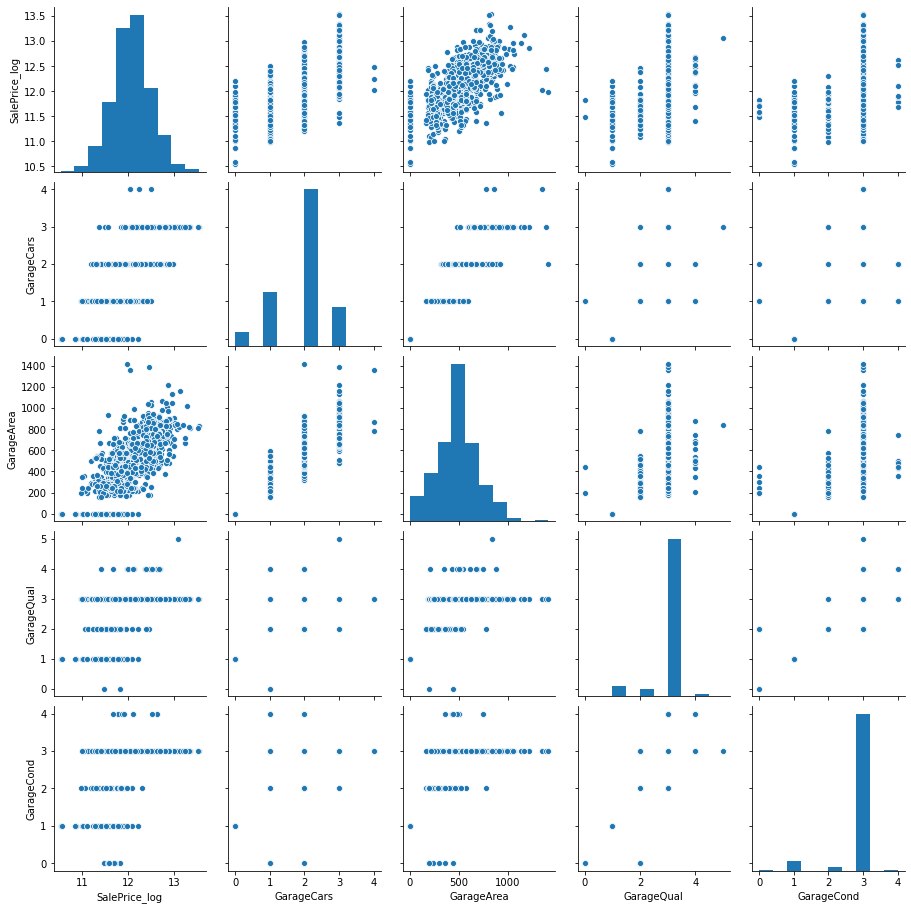

In [283]:
#### Numerical for Garage
sns.pairplot(df[['SalePrice_log', 'GarageCars', 'GarageArea', 'GarageQual','GarageCond']])

##### Summary:
GarageQual and GarageCond seem very similar in the data description. We observe a high correlation and can therefore remove one of them. We will remove GarageCond.
GarageCars represents width, given that the more cars, most likely, the wider the garage. Garage area is the total square ft. They do tell some of them same story, but are not exactly the same. We chose to keep both for now. 

In [284]:
df.drop('GarageCond', axis = 1, inplace = True)

### 3.3

#### Kitchen

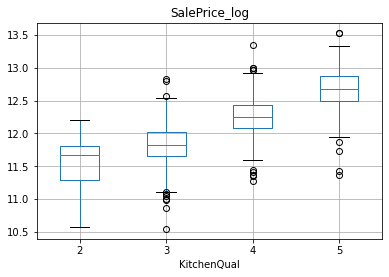

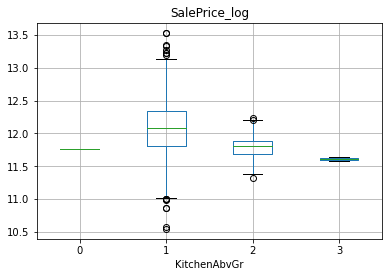

1    1146
2      49
3       2
0       1
Name: KitchenAbvGr, dtype: int64


In [285]:
df['KitchenQual'] = df.KitchenQual.replace(rank_dict)

for kitchen in ['KitchenQual', 'KitchenAbvGr']:
    df.boxplot(column = 'SalePrice_log', by = kitchen)
    plt.suptitle('')
    plt.show()
    
print(df.KitchenAbvGr.value_counts())

We drop KitchenAbvGr as it has limited observations for any other category than 1 and the distributions appear overlapping. 

In [286]:
df.drop('KitchenAbvGr', axis = 1, inplace = True)

### 3.4

#### Fireplace

In [287]:
df["FireplaceQu"] = df.FireplaceQu.replace(rank_dict)

In [288]:
corr = df[['SalePrice_log','FireplaceQu', 'Fireplaces']].corr()
corr.style.background_gradient(cmap='coolwarm')

,SalePrice_log,FireplaceQu,Fireplaces
SalePrice_log,1.000000,0.554494,0.497042
FireplaceQu,0.554494,1.000000,0.819237
Fireplaces,0.497042,0.819237,1.000000


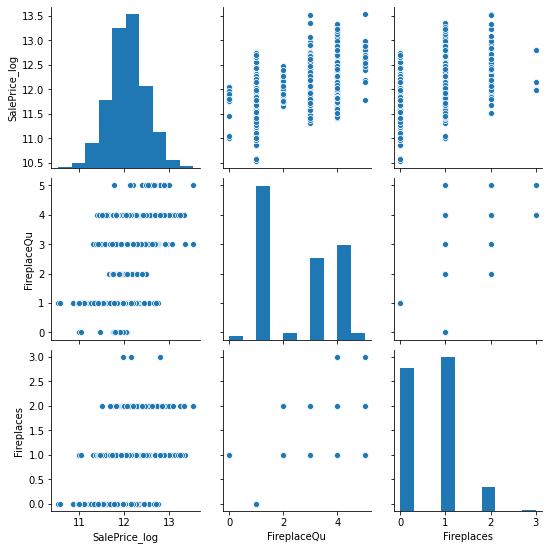

In [289]:
sns.pairplot(df[['SalePrice_log','FireplaceQu', 'Fireplaces']])

Fireplaces appear to have some predictive power as more (any) fireplaces predicts higher prices. We will keep both variables.

### 3.5

#### Pool

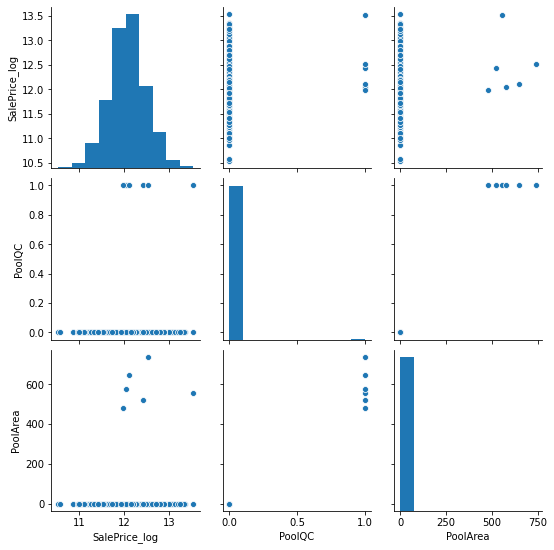

In [290]:
sns.pairplot(df[['SalePrice_log','PoolQC', 'PoolArea']])

Naturally, we would have expected a pool to increase prices. But it appear slightly average 

### 3.6

#### Porch

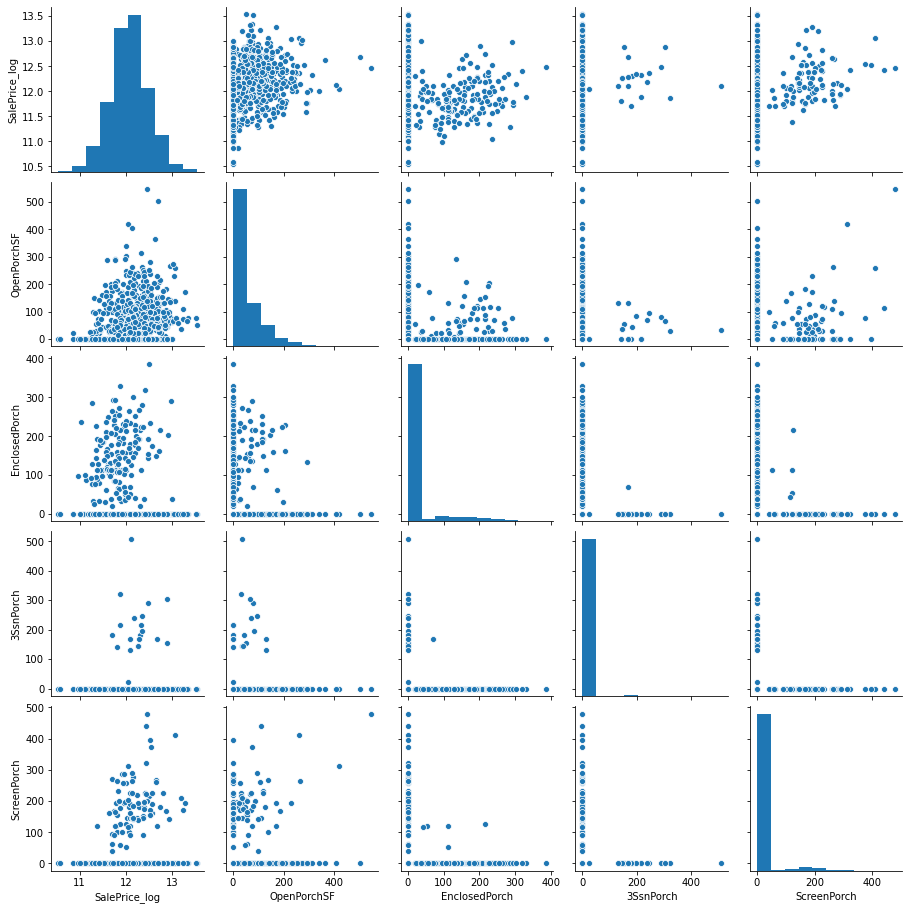

In [291]:
porchCols = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

sns.pairplot(df[['SalePrice_log'] + porchCols])

In [292]:
corr =df[['SalePrice_log'] + porchCols].corr()
corr.style.background_gradient(cmap='coolwarm')

,SalePrice_log,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
SalePrice_log,1.000000,0.349683,-0.150564,0.052129,0.118148
OpenPorchSF,0.349683,1.000000,-0.112583,-0.006227,0.090972
EnclosedPorch,-0.150564,-0.112583,1.000000,-0.035515,-0.074650
3SsnPorch,0.052129,-0.006227,-0.035515,1.000000,-0.030329
ScreenPorch,0.118148,0.090972,-0.074650,-0.030329,1.000000


From the scatter plots we observe that most observations have open porches or no porch. All variables are kept. 

### 3.7

####  Bath

In [293]:
corr =df[['SalePrice_log','FullBath', 'HalfBath']].corr()
corr.style.background_gradient(cmap='coolwarm')

,SalePrice_log,FullBath,HalfBath
SalePrice_log,1.000000,0.591848,0.290486
FullBath,0.591848,1.000000,0.116346
HalfBath,0.290486,0.116346,1.000000


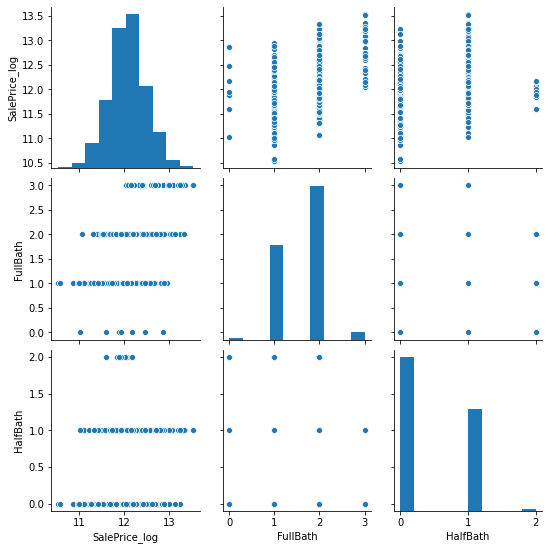

In [294]:
sns.pairplot(df[['SalePrice_log','FullBath', 'HalfBath']])

The FullBath variable appears to capture some information about pricing. We will drop HalfBath.

In [295]:
df.drop('HalfBath', axis = 1, inplace = True)

### 3.8

####  Heating

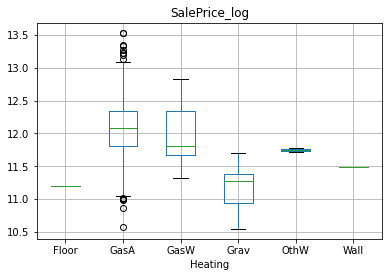

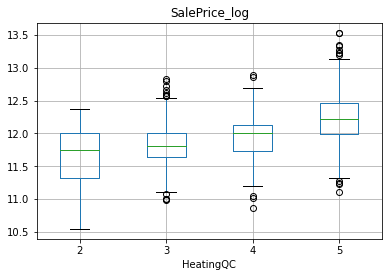

In [246]:
df['HeatingQC'] = df.HeatingQC.replace(rank_dict)

for heating in ['Heating', 'HeatingQC']:
    df.boxplot(column = 'SalePrice_log', by = heating)
    plt.suptitle('')
    plt.show()

Both variables are kept

### 3.9

####  Masonry

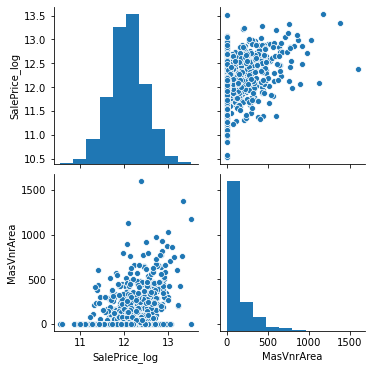

In [247]:
sns.pairplot(df[['SalePrice_log','MasVnrArea']])

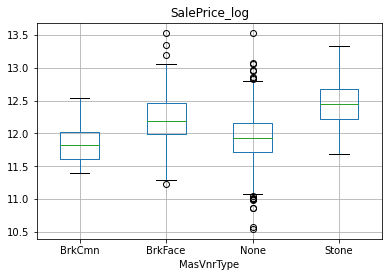

In [248]:
df.boxplot(column = 'SalePrice_log', by = 'MasVnrType')
plt.suptitle('')
plt.show()

From the boxplot we can see some relationship between masonary area and sales price, can also be somewhat explained by the different types of masonary. Both will be kept.

### 3.10

####  Miscellaneous

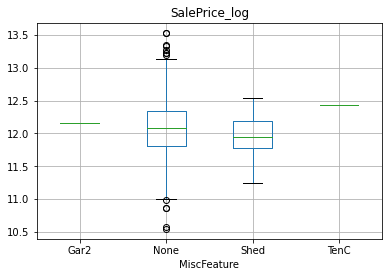

In [249]:
df.boxplot(column = 'SalePrice_log', by = 'MiscFeature')
plt.suptitle('')
plt.show()

In [250]:
df.MiscFeature.value_counts()

None    1162
Shed      34
TenC       1
Gar2       1
Name: MiscFeature, dtype: int64

We drop MiscFeature given a lack of observations for TenC and Gar2, while the Shed observations overlap with the None category.

In [251]:
df.drop('MiscFeature', axis = 1, inplace = True)

### 3.11
#### Age

In [252]:
df['age'] = df['YrSold'] - df['YearBuilt']
df.drop(['YrSold', 'YearBuilt'], axis = 1, inplace = True)

### Drop additional variables before storing final df

In [253]:
# Drop Exterior2nd and Condition2 as it is almost the same as Exterior1st and Condition1
df.drop(['Exterior2nd', 'Condition2'], axis = 1, inplace = True)

### 3.12

####  Other Features (Converted to Dummies)

In [254]:
otherFeatures = ['MSZoning', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 
'RoofStyle', 'RoofMatl', 'Exterior1st', 'ExterQual', 'ExterCond', 'Foundation', 'CentralAir', 
'Electrical', 'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Functional',  'YearRemodAdd',
'PavedDrive', 'WoodDeckSF', 'Fence', 'MoSold', 'YrSold', 'SaleType', 'LotFrontage', 'SaleCondition']


categorical_df = df.loc[:,(df.dtypes == 'object')]

# Generate final df for analysis
final_df = pd.get_dummies(data=df,columns=categorical_df.columns, prefix=categorical_df.columns)

# Drop all 'None' features to get more informative output and avoid multicollinearity 
# (This is relevant for alley, fireplace, pool etc)
final_df = final_df[final_df.columns.drop(list(final_df.filter(regex='_None')))]

# Drop a variable from each categorical feature without a 'None' category
final_df.drop(['MSZoning_RM', 'LotShape_IR1', 'LandContour_Bnk', 'Utilities_AllPub', 'LotConfig_Corner', 'LandSlope_Gtl', 
               'Condition1_RRNe', 'BldgType_TwnhsE', 'HouseStyle_SLvl', 'RoofStyle_Flat', 
               'RoofMatl_ClyTile', 'Exterior1st_AsbShng', 'ExterQual_Ex', 'Foundation_BrkTil',
               'Heating_Wall', 'Electrical_FuseP', 'Functional_Mod', 'GarageType_2Types', 'GarageFinish_0',
               'PavedDrive_P', 'SaleType_COD', 'SaleCondition_Abnorml', 'ExterCond_Fa', 'CentralAir_N', 
               'Street_Grvl'], axis = 1, inplace = True)

# Drop latitude and Longitude features, as they are not needed for the regression models
final_df.drop(['Latitude', 'Longitude'], axis = 1, inplace = True)

In [255]:
final_df.to_csv('df_FeatureSelection.csv', index = False)

## Charts

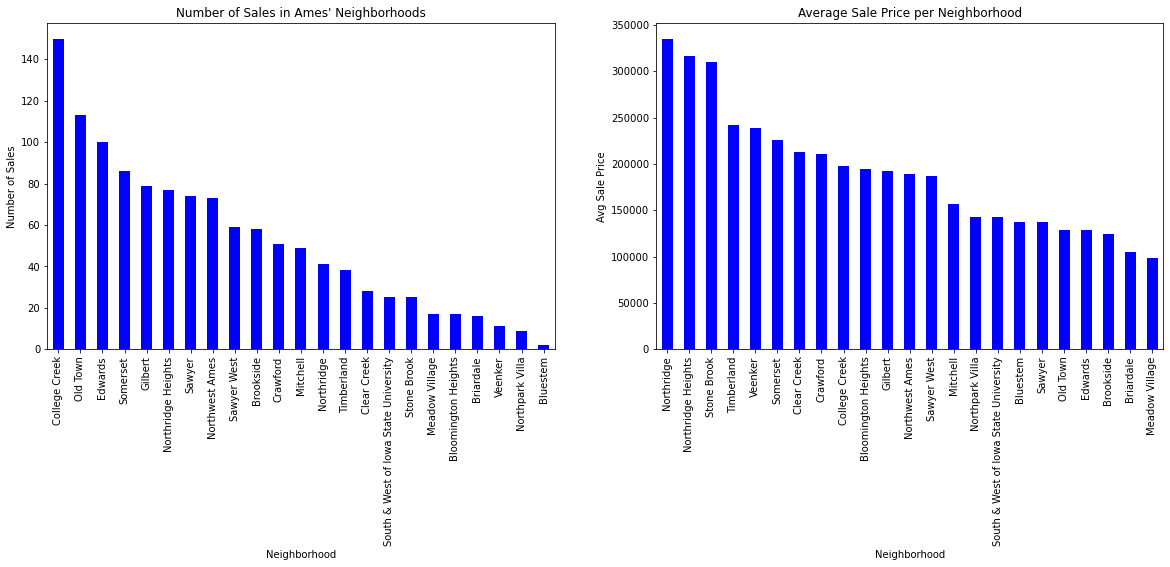

In [256]:
# Number of sales in each neighborhood
sales_nbh = df['Neighborhood'].value_counts()
sales_nbh.columns = ['Number of Sales']


# Avg sale price in each neighborhood
nbhAvgPrice = df.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending = False)
nbhAvgPrice = nbhAvgPrice.to_frame().rename(columns={'SalePrice': 'AvgSalePrice'})
nbhAvgPrice['AvgSalePrice'] = nbhAvgPrice['AvgSalePrice'].round(2)

# Bar Plots
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot)

sales_nbh.plot(kind = 'bar', color='blue', figsize=(20, 6), ax=ax0)
ax0.set_title('Number of Sales in Ames\' Neighborhoods')
ax0.set_xlabel('Neighborhood')
ax0.set_ylabel('Number of Sales')

nbhAvgPrice['AvgSalePrice'].plot(kind='bar', color = 'blue', figsize=(20, 6), ax=ax1) # add to subplot 2
ax1.set_title ('Average Sale Price per Neighborhood')
ax1.set_xlabel('Neighborhood')
ax1.set_ylabel('Avg Sale Price')

plt.show()

In [258]:
#Get latitude and longitudes
API_KEY = 'b6b42744d9454990a83302a20001bc38'
nbh_list = list(nbhAvgPrice.index)
nbhAvgPrice['Latitude'], nbhAvgPrice['Longitude'] = getLatLng(nbh_list, API_KEY)

In [259]:
nbhAvgPrice['Neighborhood'] = nbhAvgPrice.index

In [260]:
# Visual plot
# create map of Ames using latitude and longitude values
ames_latitude = 42.034534
ames_longitude = -93.620369

map_ames = folium.Map(location=[ames_latitude, ames_longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood, avgPrice in zip(nbhAvgPrice['Latitude'], nbhAvgPrice['Longitude'], nbhAvgPrice['Neighborhood'], nbhAvgPrice['AvgSalePrice']):
    label = '{}, Average Sales Price: {}'.format(neighborhood, avgPrice)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ames)  

display(map_ames)

Note that some neighborhoods are almost overlapping precisely. These are most likely identical in terms of nearby venues. Note that Old Town, Gilbert and Northpark Villa are all located far outside Ames city. 